# E2: Applying Transformers to the Corpus

This notebook is used to apply and analyze measures on the Switchboard corpus via a series of ConvoKit Transformers.

### Import dependencies and load corpus

In [1]:
import os
os.chdir("../../") # import convokit
from convokit import Corpus, User, Utterance
os.chdir("datasets/switchboard-corpus") # then come back for switchboard
import convokit
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer

In [2]:
# Load the switchboard corpus
corpus = convokit.Corpus(filename = "./corpus")

In [3]:
# Function to use for tokenizing utterances
def tokenize_utt(utterance: str):
    # Strips punctuation from utterance and returns a list of tokens
    tokenizer = RegexpTokenizer(r'\w+')	
    tokens = tokenizer.tokenize(utterance)

    # Remove any tokens that are a single letter other than 'I' or 'a'
    # because they are tags for the utterance tree
    for t in tokens:
        if len(t) == 1 and not (t == 'I' or t == 'a'):
            tokens.remove(t)
    return tokens

### Apply all the transformers

In [4]:
# Apply the ConversationBalance transformer
cb = convokit.ConversationBalance()
cb.transform(corpus)

In [5]:
# Apply the VocabOverlap transformer
vo = convokit.VocabOverlap()
vo.transform(corpus)

In [6]:
# Apply the FirstImpression transformer
fi = convokit.FirstImpression()
fi.transform(corpus)

In [7]:
# Apply the DAMSLScores transformer
ds = convokit.DAMSLScores('../../convokit/damslScores/damsl_rubric.txt')
ds.transform(corpus)

### Measure 1: Conversation Balance

Let's confirm the changes to the corpus. The conversation balance is saved as an array of size NxN where N is the number of users. Cell (X,Y) in the array is the ratio of number of tokens said by User A to the total number of tokens.

In [8]:
for i, c in enumerate(corpus.iter_conversations()):
    balance = c.meta['conversation_balance']
    print(i+1,')  Balance from User 1 to User 2:', balance[0,1])
    
    if i == 2:
        break
        
print('We can see from this that the balance of convo 1 is the best because it is closest to 0.5')
print('In conversation 2, we see that User 2 speaks twice as much as User 1 (0.33 = 1/(1+2))')
print('Conversation 3 is similar to conversation 1 and is about equal.')

1 )  Balance from User 1 to User 2: 0.5430539609644087
2 )  Balance from User 1 to User 2: 0.33425925925925926
3 )  Balance from User 1 to User 2: 0.5761589403973509
We can see from this that the balance of convo 1 is the best because it is closest to 0.5
In conversation 2, we see that User 2 speaks twice as much as User 1 (0.33 = 1/(1+2))
Conversation 3 is similar to conversation 1 and is about equal.


Let's look at the balance within a conversation. Here, we will call each group of consecutive utterances by the same User a statement. The statement balance is stored in the first utterance of a statement. It tells us the ratio of tokens of the current statement to the sum of the current statement's tokens and the next statement's tokens.

In [9]:
# Looking at just one conversation:
print('Users in this conversation:', corpus.conversations['2095-0']._usernames)

print('\nHere are the IDs for the first 5 utterances of the conversation, and the balance from',
     '\nthis utterance to the next:')
utt_list = corpus.conversations['2095-0']._utterance_ids
for i, u in enumerate(utt_list):
    if 'statement_balance' in corpus.utterances[u].meta:
        print(u, corpus.utterances[u].meta['statement_balance'])
        
    if i > 4:
        break
    

Users in this conversation: ['1169', '1221']

Here are the IDs for the first 5 utterances of the conversation, and the balance from 
this utterance to the next:
2095-0 0.47368421052631576
2095-1 0.9090909090909091
2095-3 0.037037037037037035
2095-4 0.37142857142857144
2095-5 0.8


For this conversation, let's see how the statement balance plots over the length of the conversation

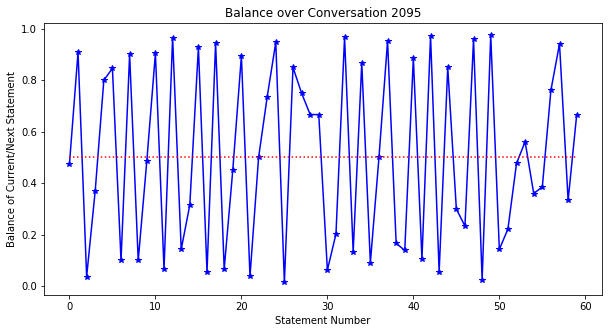

In [10]:
utt_list = corpus.conversations['2095-0']._utterance_ids
statement_ids = []
statement_balances = []

for u in utt_list:
    if 'statement_balance' in corpus.utterances[u].meta:
        statement_ids.append(u)
        statement_balances.append(corpus.utterances[u].meta['statement_balance'])
    
plt.figure(figsize=(10,5))
plt.plot(range(len(statement_balances)), statement_balances, 'b*-')
plt.plot(range(len(statement_balances)), 0.5*np.ones(len(statement_balances)), 'r:')
plt.title('Balance over Conversation 2095')
plt.xlabel('Statement Number')
plt.ylabel('Balance of Current/Next Statement')
plt.show()

What is the average balance over the first 10% of each conversation?

In [11]:
beg_balance = []
rest_balance = []

for c in corpus.conversations:
    utt_list = corpus.conversations[c]._utterance_ids
    statement_ids = []
    statement_balances = []
    
    # Get list of statement balances
    for u in utt_list:
        if 'statement_balance' in corpus.utterances[u].meta:
            statement_ids.append(u)
            statement_balances.append(corpus.utterances[u].meta['statement_balance'])
            
    # Split up the statements to different parts of the conversation
    split = round(0.1*len(statement_balances))

    beginning = statement_balances[:split]
    rest = statement_balances[split:]
    assert(len(beginning)+len(rest) == len(statement_balances))
    beg_balance.append(sum(beginning)/len(beginning))
    rest_balance.append(sum(rest)/len(rest))
        
print('The average balance of the first 10% of the conversation is:', sum(beg_balance)/len(beg_balance))
print('The average balance of the rest of the conversation is:', sum(rest_balance)/len(rest_balance))

The average balance of the first 10% of the conversation is: 0.5047168510835116
The average balance of the rest of the conversation is: 0.49750780249417964


Based on this, it doesn't seem as though the first 10% of a conversation has a different balance than the rest. Let's look at the balance in other parts of the conversation.

In [12]:
beg_balance = []
rest_balance = []

for c in corpus.conversations:
    utt_list = corpus.conversations[c]._utterance_ids
    statement_ids = []
    statement_balances = []
    
    # Get list of statement balances
    for u in utt_list:
        if 'statement_balance' in corpus.utterances[u].meta:
            statement_ids.append(u)
            statement_balances.append(corpus.utterances[u].meta['statement_balance'])

    # Split up the statements to different parts of the conversation
    beginning = statement_balances[:2]
    rest = statement_balances[2:]
    assert(len(beginning)+len(rest) == len(statement_balances))
    beg_balance.append(sum(beginning)/len(beginning))
    rest_balance.append(sum(rest)/len(rest))
        
print('The average balance of the first exchange of the conversation is:', sum(beg_balance)/len(beg_balance))
print('The average balance of the rest of the conversation is:', sum(rest_balance)/len(rest_balance))

The average balance of the first exchange of the conversation is: 0.5222111310312094
The average balance of the rest of the conversation is: 0.4976386388403285


In [13]:
beg_balance = []
mid_balance = []
end_balance = []

for c in corpus.conversations:
    utt_list = corpus.conversations[c]._utterance_ids
    statement_ids = []
    statement_balances = []
    
    # Get list of statement balances
    for u in utt_list:
        if 'statement_balance' in corpus.utterances[u].meta:
            statement_ids.append(u)
            statement_balances.append(corpus.utterances[u].meta['statement_balance'])
            
    # Split up the statements to different parts of the conversation
    split1 = round(0.2*len(statement_balances))
    split2 = round(0.8*len(statement_balances))

    beginning = statement_balances[:split1]
    middle = statement_balances[split1:split2]
    end = statement_balances[split2:]
    
    assert(len(beginning)+len(middle)+len(end) == len(statement_balances))
    
    beg_balance.append(sum(beginning)/len(beginning))
    mid_balance.append(sum(middle)/len(middle))
    end_balance.append(sum(end)/len(end))
        
print('The average balance of the beginning of the conversation is:', sum(beg_balance)/len(beg_balance))
print('The average balance of the middle of the conversation is:', sum(mid_balance)/len(mid_balance))
print('The average balance of the end of the conversation is:', sum(end_balance)/len(end_balance))

The average balance of the beginning of the conversation is: 0.5001333376963868
The average balance of the middle of the conversation is: 0.49803484584253266
The average balance of the end of the conversation is: 0.4968326232051664


There is also very little difference between the middle and end of the conversation. It may be that there is no general pattern in conversation balance in this dataset.

### Measure 2: Overlapping use of vocabulary

Next we move onto use of overlapping vocabulary. Our hypothesis is that people tend to repeat what the other person says if the users are more engaged in the conversation. This measurement computes the proportion of tokens that are used by all users, while excluding stop words commonly used such as 'a', 'is', and 'or'.

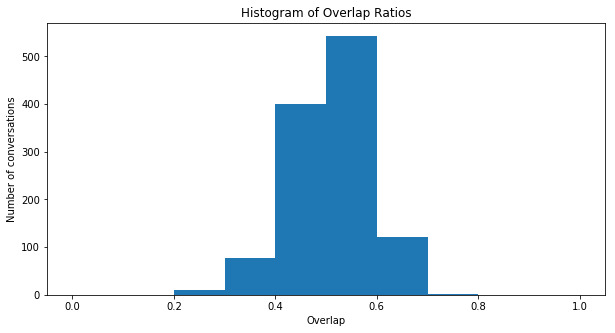

Mean = 0.509310 / StDev = 0.075667


In [14]:
overlaps = []
for i, convo in enumerate(corpus.iter_conversations()):
    
    overlaps.append(convo.meta['vocabulary_overlap']['ratio'])
        
plt.figure(figsize=(10,5))
plt.hist(overlaps, bins = np.linspace(0,1,num=11))
plt.title('Histogram of Overlap Ratios')
plt.xlabel('Overlap')
plt.ylabel('Number of conversations')
plt.show()

print('Mean = %f / StDev = %f' % (np.mean(overlaps), np.std(overlaps)))

From the histogram above, we see that the overlap ratio in conversations ranges within 0.3 to 0.8.

In [15]:
# Observe what words are overlapping across different users
for i, convo in enumerate(corpus.iter_conversations()):
    
    vo = convo.meta['vocabulary_overlap']
    print('+ Overlapping words in convo %s: %s\n' % (convo.id, vo['vocab']))
    if i == 2:
        break

+ Overlapping words in convo 4325-0: {'think', 'one', 'well', 'oh', 'large', 'kids', 'though', 'starts', 'right', 'never', 'kind', 'usually', 'something', 'take', 'laughter', 'okay', 'place', 'huh', 'day', 'would', 'home', 'get', 'community', 'um', 'different', 'watch', 'yes', 'care', 'lucky', 'work', 'yeah', 'sister', 'uh', 'know', 'like', 'time', 'real', 'really'}

+ Overlapping words in convo 4330-0: {'rigs', 'test', 'go', 'little', 'even', 'interesting', 'well', 'lot', 'policies', 'right', 'parties', 'drugs', 'kind', 'equipment', 'engineer', 'since', 'something', 'case', 'job', 'policy', 'testing', 'laughter', 'subjected', 'screening', 'huh', 'random', 'get', 'um', 'company', 'work', 'uh', 'guess', 'know', 'like', 'drug', 'tested', 'people', 'nature', 'really', 'mean', 'got'}

+ Overlapping words in convo 4103-0: {'college', 'working', 'going', 'little', 'one', 'interesting', 'well', 'oh', 'fund', 'lot', 'book', 'point', 'check', 'kind', 'back', 'balanced', 'range', 'wife', 'start'

We see that using just stop words still leaves some commonly used words with less content. Also, repeated usage of rare words should be more significant for our purpose, and thus one extension from here would be to apply an additional filter.

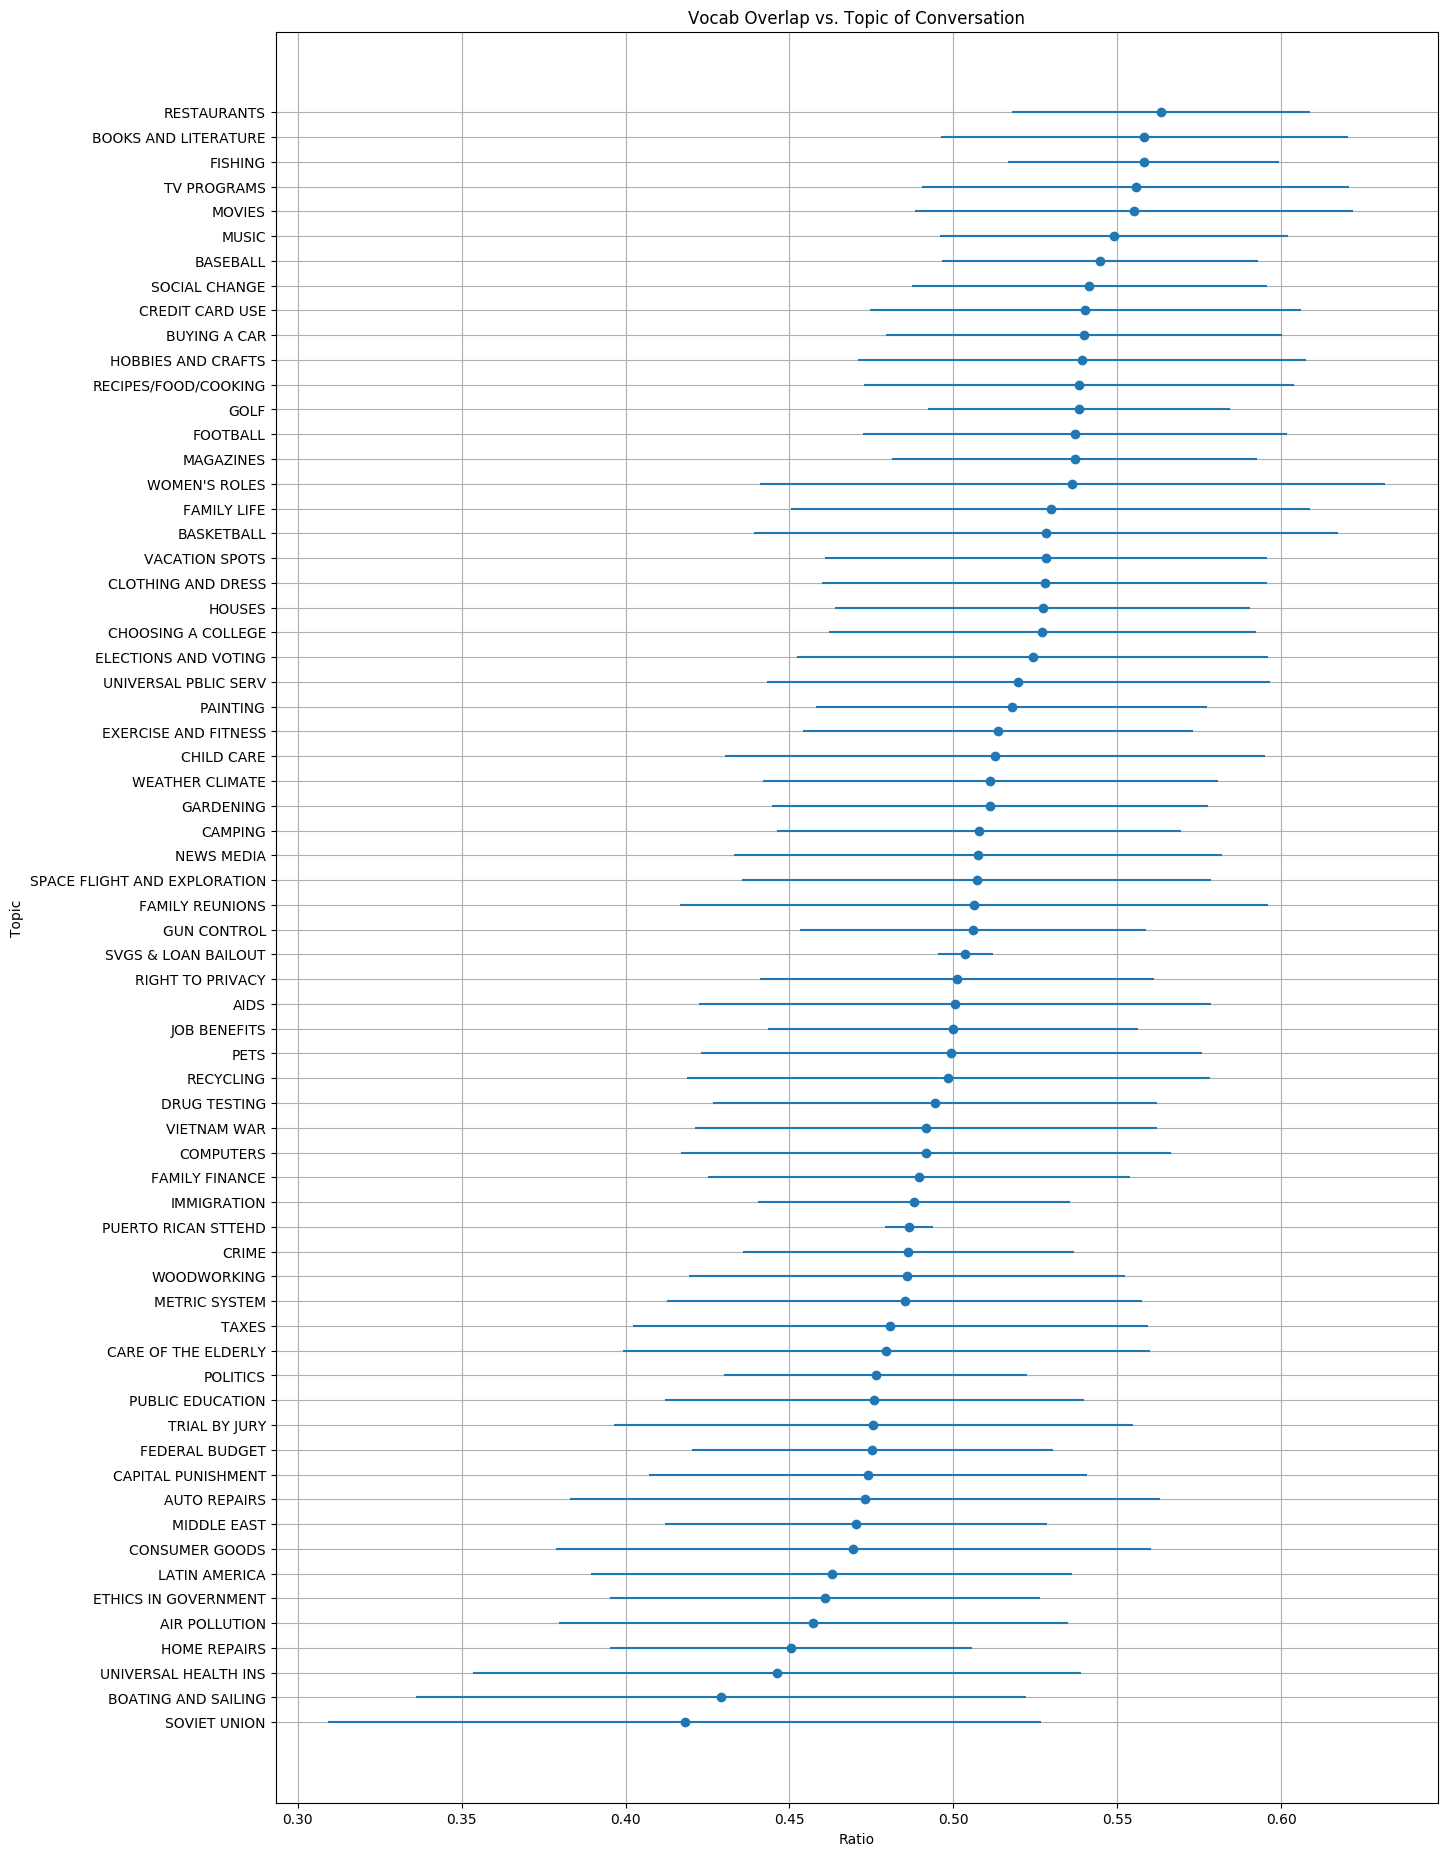

In [16]:
# Investigate whether different topics of conversaition leads to
# more or less overlapping vocabulary amongst the users
topicCounts = {}
topicOverlap = {}
for conv_id in corpus.meta['metadata']:
    
    topic = corpus.meta['metadata'][conv_id]['topic_description']
    
    convo = corpus.conversations[conv_id + '-0']
    overlap = convo.meta['vocabulary_overlap']['ratio']
    
    if topic not in topicCounts:
        topicCounts[topic] = 1
        topicOverlap[topic] = [overlap]
    else:
        topicCounts[topic] += 1
        topicOverlap[topic].append(overlap)

means = []
stds = []
for overlap in topicOverlap.values():
    means.append(np.mean(overlap))
    stds.append(np.std(overlap))
        
# Sort by the average vocab overlap
idx = np.argsort(means)
    
# Plot politeness scores for each topic (error bar showing 1 standard deviation)
x = np.arange(len(means))

means = np.array(means)
stds = np.array(stds)

plt.rcdefaults()
plt.figure(figsize=(15, 23))
plt.errorbar(means[idx], x, xerr=stds[idx], linestyle='None', marker='o')
plt.yticks(x, [list(topicOverlap.keys())[i] for i in idx])
plt.grid()
plt.title('Vocab Overlap vs. Topic of Conversation')
plt.xlabel('Ratio')
plt.ylabel('Topic')
plt.show()

Here, we see an interesting trend in which easily accessible topics such as fishing, movies, and baseball show larger overlap within vocabularies, whereas topics requiring rather more knowledge such as soviet union, ethics in government, and air pollution show less overlap.

### Measure 3: Scores measured with DAMSL tags

Among 43 different DAMSL act-tags shown in Table 3 of http://compprag.christopherpotts.net/swda.html, we believe some tags are indicative of engaging and useful interactions within conversations (e.g. acknowledgement or reformulation), whereas others indicate less-quality conversations (e.g. Uninterpretable or 3rd-party talk). 

By checking example utterances with each tag, we classified each tag by hand, after which each tag has a score based on its indication: +1 (good interaction), 0 (neutral), and -1 (bad interaction). This hand-crafted rubric can be found in `/convokit/damslScores/damsl_rubric.txt`. Out of 43 DAMSL tags, 21 tags are marked as +1, 8 tags as -1, and 14 tags as 0. The final DAMSL score stored in the conversation-level metadata under key `damsl_score` is simply the average of the scores across all utterances within the conversation.

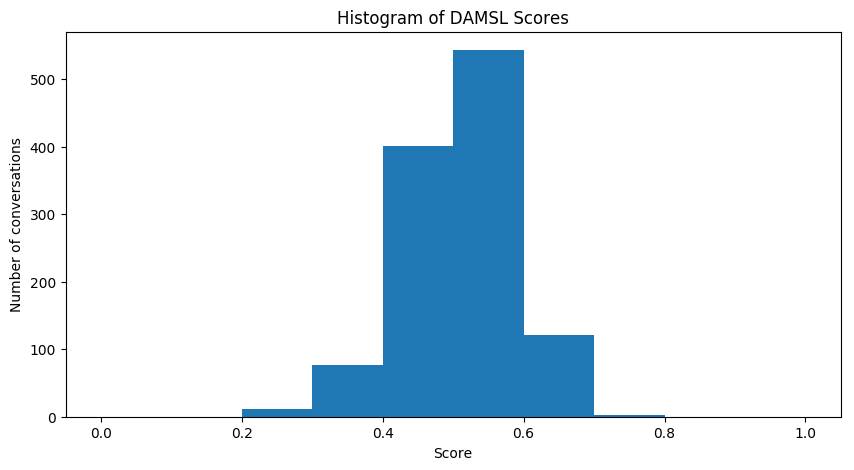

Mean = 0.646245 / StDev = 0.079723


In [17]:
scores = []
for i, convo in enumerate(corpus.iter_conversations()):
    scores.append(convo.meta['damsl_score'])
    
plt.figure(figsize=(10,5))
plt.hist(overlaps, bins = np.linspace(0,1,num=11))
plt.title('Histogram of DAMSL Scores')
plt.xlabel('Score')
plt.ylabel('Number of conversations')
plt.show()

print('Mean = %f / StDev = %f' % (np.mean(scores), np.std(scores)))

We see that all scores reside on the positive side, which is expected as we assigned half of the tags as +1, and a lot less as -1. A lot of frequent tags are also often tagged as +1, further pushing the average towards the positive side.

Instead of hand-crafting the points naively as +1 or -1, it would be helpful to have a DAMSL-tagged dataset with human-annotated conversation quality scores, with which we can build a regression model to learn the suitable weights of each tag.

### Measure 4: Sentiment analysis for first impressions

Lastly, we perform sentiment analysis on the utterances that cover the first 10% of each conversation, to represent how good or bad the users' first impressions were. We use the pretrained NLTK VADER sentiment analyzer, in which there are four metrics:
- `neg/neu/pos`: These represent the negative/neutral/positive sentiments of an utterance/conversation. Each of these range within [0,1], and the three sums up to 1.
- `compound`: This aggregated score ranges from -1 (extreme negative) to +1 (extreme positive), and is computed by iterating through a lexicon with several heuristics. For further detail, please refer to http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf. We will mainly use this metric to check our hypothesis.

In [18]:
# Print out sample initial utterances for sanity-check
i = 0
for k, v in corpus.meta['metadata'].items():
    
    from_caller = v['from_caller']
    to_caller = v['to_caller']
    convo = corpus.conversations[k+'-0']
    print('+ Conversation %s' % k)
    print('- Polarity score of from-caller (%s) = %f' % (from_caller, convo.meta['first_impression'][from_caller]['compound']))
    print('- Polarity score of to-caller   (%s) = %f' % (to_caller, convo.meta['first_impression'][to_caller]['compound']))
    print('- Sample beginning text:')
    for idx, utt in enumerate(convo.iter_utterances()):
        tokens = tokenize_utt(utt.text)
        if utt.user.name == from_caller:
            print('  (FROM): %s' % ' '.join(tokens))
        else:
            print('  ( TO ): %s' % ' '.join(tokens))
        if idx > 15:
            break
            
    print('\n')
    i += 1
    if i > 10:
        break

+ Conversation 4325
- Polarity score of from-caller (1632) = 0.249750
- Polarity score of to-caller   (1519) = 0.361350
- Sample beginning text:
  (FROM): Okay
  (FROM): So
  ( TO ): I guess
  (FROM): What kind of experience do you do you have then with child care
  ( TO ): I think uh I wonder if that worked
  (FROM): Does it say something
  ( TO ): I think it usually does
  ( TO ): You might try uh
  ( TO ): I don know
  ( TO ): hold it down a little longer
  ( TO ): and see if it uh
  (FROM): Okay beep
  (FROM): long pause Well
  ( TO ): Okay
  ( TO ): I
  (FROM): Does it usually make a recording or
  ( TO ): Well I don remember


+ Conversation 4330
- Polarity score of from-caller (1635) = 0.136600
- Polarity score of to-caller   (1597) = 0.000000
- Sample beginning text:
  (FROM): Well uh does the company you work for test for drugs
  ( TO ): Actually uh they just recently started a policy of testing drugs which was kind of interesting
  ( TO ): because when I went to work for them

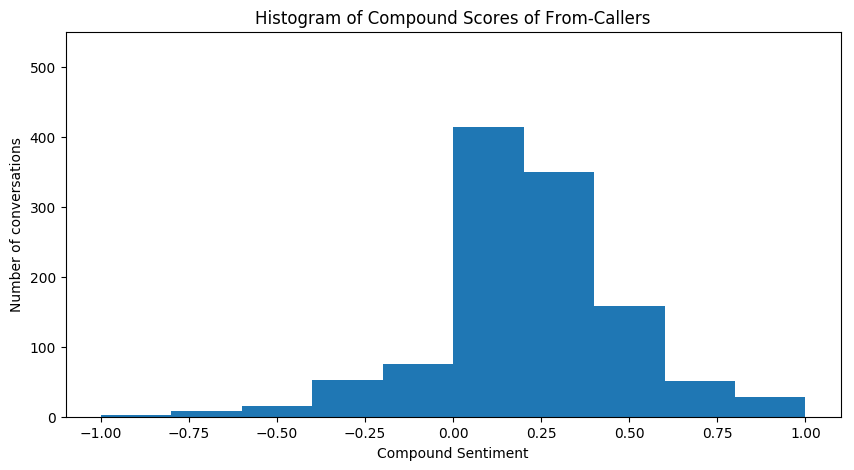

Mean = 0.198901 / StDev = 0.275779


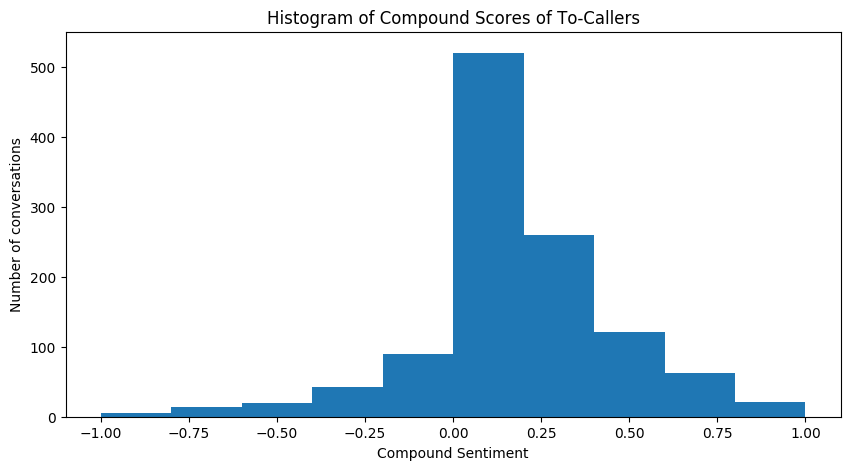

Mean = 0.153019 / StDev = 0.285121


In [19]:
compoundsFrom = []
compoundsTo = []
for k, v in corpus.meta['metadata'].items():
    
    from_caller = v['from_caller']
    to_caller = v['to_caller']
    convo = corpus.conversations[k+'-0']
    compoundsFrom.append(convo.meta['first_impression'][from_caller]['compound'])
    compoundsTo.append(convo.meta['first_impression'][to_caller]['compound'])
    
    
plt.figure(figsize=(10,5))
plt.hist(compoundsFrom, bins = np.linspace(-1,1,num=11))
plt.title('Histogram of Compound Scores of From-Callers')
plt.xlabel('Compound Sentiment')
plt.ylabel('Number of conversations')
plt.ylim(bottom=0, top=550)
plt.show()
print('Mean = %f / StDev = %f' % (np.mean(compoundsFrom), np.std(compoundsFrom)))


plt.figure(figsize=(10,5))
plt.hist(compoundsTo, bins = np.linspace(-1,1,num=11))
plt.title('Histogram of Compound Scores of To-Callers')
plt.xlabel('Compound Sentiment')
plt.ylabel('Number of conversations')
plt.ylim(bottom=0, top=550)
plt.show()
print('Mean = %f / StDev = %f' % (np.mean(compoundsTo), np.std(compoundsTo)))


Results show that the sentiment of to-callers have slightly more negative sentiments at the beginning of a conversation. This behavior is expected, as it is the from-caller's intention to call the recepient, and there may be situations where the to-caller would prefer not to start the whole conversations.

## Checking our main hypothesis

We mainly hypothesized that the first impression starting a conversation is positively correlated to the quality of the entire conversation. If the caller starts the conversation with a kind introduction with a positive tone, we would expect the receiver to be more likely to respond in a similar manner and answer the caller's questions with more detail. Conversely, if the introduction is terse and abrupt, the receiver will be less likely to cooperate or to provide thought-out and detailed responses. In essence, we test to see if measure 4 (sentiment analysis) has any correlation with the other three measurements.

### First Impression vs. Conversation Balance

We first check the correlation between the initial sentiment and the conversation balance. We use the deviation of the balance term from 0.5 to measure how good a conversation was (i.e. an ideal conversation would have 0 deviation).

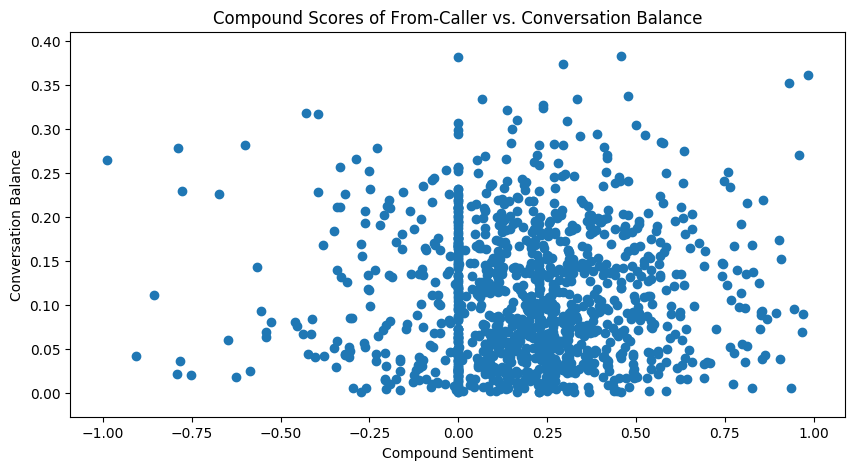

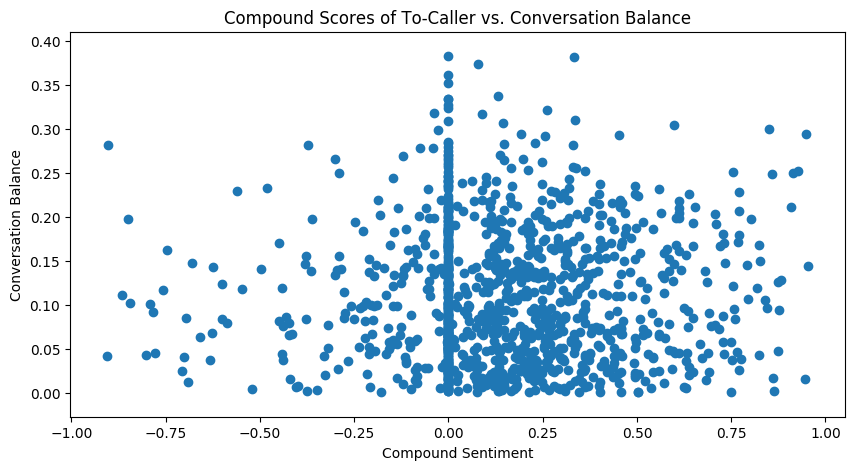

In [20]:
convoBalances = []
compoundsFrom = []
compoundsTo = []

for k, v in corpus.meta['metadata'].items():
    
    from_caller = v['from_caller']
    to_caller = v['to_caller']
    convo = corpus.conversations[k+'-0']
    
    # We measure how far the conversation balance is far from 50-50
    convoBalances.append(abs(0.5-convo.meta['conversation_balance'][0,1]))
    
    compoundsFrom.append(convo.meta['first_impression'][from_caller]['compound'])
    compoundsTo.append(convo.meta['first_impression'][to_caller]['compound'])

plt.figure(figsize=(10,5))
plt.scatter(compoundsFrom, convoBalances)
plt.title('Compound Scores of From-Caller vs. Conversation Balance')
plt.xlabel('Compound Sentiment')
plt.ylabel('Conversation Balance')
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(compoundsTo, convoBalances)
plt.title('Compound Scores of To-Caller vs. Conversation Balance')
plt.xlabel('Compound Sentiment')
plt.ylabel('Conversation Balance')
plt.show()

### First Impression vs. Overlapping use of vocab

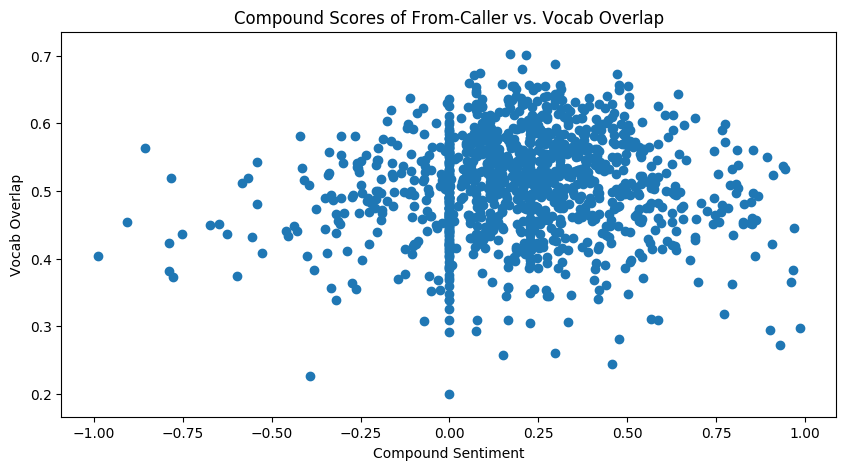

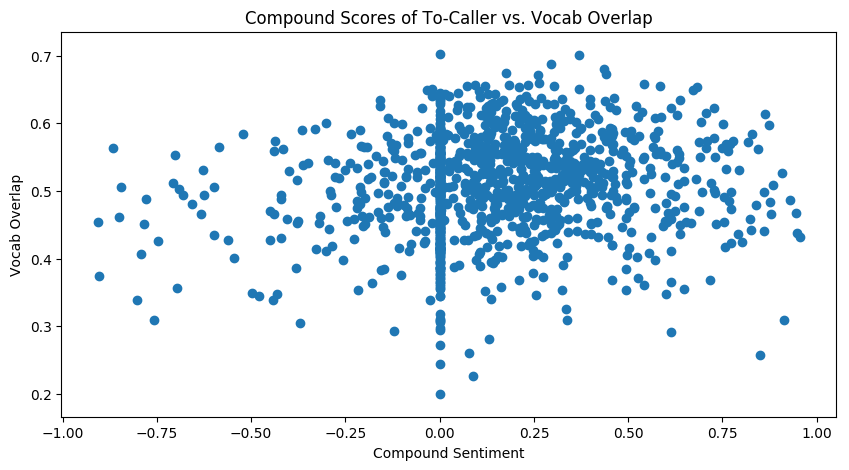

In [21]:
overlaps = []
compoundsFrom = []
compoundsTo = []

for k, v in corpus.meta['metadata'].items():
    
    from_caller = v['from_caller']
    to_caller = v['to_caller']
    convo = corpus.conversations[k+'-0']
    
    overlaps.append(convo.meta['vocabulary_overlap']['ratio'])
    
    compoundsFrom.append(convo.meta['first_impression'][from_caller]['compound'])
    compoundsTo.append(convo.meta['first_impression'][to_caller]['compound'])

plt.figure(figsize=(10,5))
plt.scatter(compoundsFrom, overlaps)
plt.title('Compound Scores of From-Caller vs. Vocab Overlap')
plt.xlabel('Compound Sentiment')
plt.ylabel('Vocab Overlap')
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(compoundsTo, overlaps)
plt.title('Compound Scores of To-Caller vs. Vocab Overlap')
plt.xlabel('Compound Sentiment')
plt.ylabel('Vocab Overlap')
plt.show()

### First impression vs. DAMSL act-tag scores

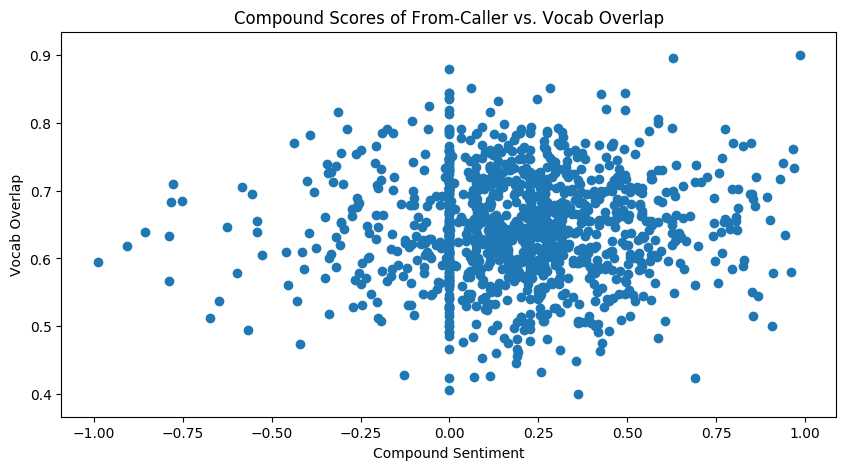

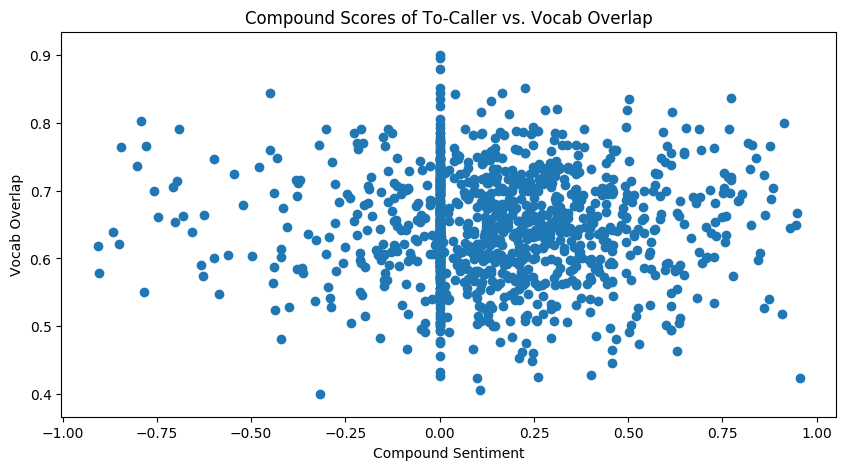

In [22]:
scores = []
compoundsFrom = []
compoundsTo = []

for k, v in corpus.meta['metadata'].items():
    
    from_caller = v['from_caller']
    to_caller = v['to_caller']
    convo = corpus.conversations[k+'-0']
    
    scores.append(convo.meta['damsl_score'])
    
    compoundsFrom.append(convo.meta['first_impression'][from_caller]['compound'])
    compoundsTo.append(convo.meta['first_impression'][to_caller]['compound'])

plt.figure(figsize=(10,5))
plt.scatter(compoundsFrom, scores)
plt.title('Compound Scores of From-Caller vs. Vocab Overlap')
plt.xlabel('Compound Sentiment')
plt.ylabel('Vocab Overlap')
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(compoundsTo, scores)
plt.title('Compound Scores of To-Caller vs. Vocab Overlap')
plt.xlabel('Compound Sentiment')
plt.ylabel('Vocab Overlap')
plt.show()